#Import dataset from drive (Zip File)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/Frood_Drive/D_10.zip

Streaming output truncated to the last 5000 lines.
  inflating: D_10/Spoil Orange/62.jpg  
  inflating: D_10/Spoil Orange/620.jpg  
  inflating: D_10/Spoil Orange/621.jpg  
  inflating: D_10/Spoil Orange/622.jpg  
  inflating: D_10/Spoil Orange/623.jpg  
  inflating: D_10/Spoil Orange/624.jpg  
  inflating: D_10/Spoil Orange/625.jpg  
  inflating: D_10/Spoil Orange/626.jpg  
  inflating: D_10/Spoil Orange/627.jpg  
  inflating: D_10/Spoil Orange/628.jpg  
  inflating: D_10/Spoil Orange/629.jpg  
  inflating: D_10/Spoil Orange/63.jpg  
  inflating: D_10/Spoil Orange/630.jpg  
  inflating: D_10/Spoil Orange/631.jpg  
  inflating: D_10/Spoil Orange/632.jpg  
  inflating: D_10/Spoil Orange/633.jpg  
  inflating: D_10/Spoil Orange/634.jpg  
  inflating: D_10/Spoil Orange/635.jpg  
  inflating: D_10/Spoil Orange/636.jpg  
  inflating: D_10/Spoil Orange/637.jpg  
  inflating: D_10/Spoil Orange/638.jpg  
  inflating: D_10/Spoil Orange/639.jpg  
  inflating: D_10/Spoil Orange/64.jpg  
  inflati

#Main process

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/D_10',
    color_mode='rgb',
    label_mode = 'categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/D_10',
    color_mode='rgb',
    label_mode = 'categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
)

Found 20107 files belonging to 10 classes.
Using 16086 files for training.
Found 20107 files belonging to 10 classes.
Using 4021 files for validation.


In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [7]:
#class_names = train_dataset.class_names

print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset).numpy())
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset).numpy())
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset).numpy())

Number of training batches: 503
Number of validation batches: 63
Number of test batches: 63


In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

IMG_SHAPE = (224,224) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
base_model.trainable = False

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [12]:
prediction_layer = tf.keras.layers.Dense(10, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

In [13]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [15]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

63/63 [==============================] - 11s 77ms/step - loss: 2.6715 - accuracy: 0.1207
initial loss: 2.67
initial accuracy: 0.12


In [16]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
503/503 [==============================] - 50s 93ms/step - loss: 1.0756 - accuracy: 0.6666 - val_loss: 0.4344 - val_accuracy: 0.9037
Epoch 2/10
503/503 [==============================] - 43s 84ms/step - loss: 0.3406 - accuracy: 0.9206 - val_loss: 0.2286 - val_accuracy: 0.9551
Epoch 3/10
503/503 [==============================] - 43s 84ms/step - loss: 0.2133 - accuracy: 0.9500 - val_loss: 0.1587 - val_accuracy: 0.9701
Epoch 4/10
503/503 [==============================] - 43s 84ms/step - loss: 0.1589 - accuracy: 0.9622 - val_loss: 0.1308 - val_accuracy: 0.9726
Epoch 5/10
503/503 [==============================] - 43s 84ms/step - loss: 0.1258 - accuracy: 0.9702 - val_loss: 0.1028 - val_accuracy: 0.9786
Epoch 6/10
503/503 [==============================] - 43s 84ms/step - loss: 0.1046 - accuracy: 0.9746 - val_loss: 0.0903 - val_accuracy: 0.9791
Epoch 7/10
503/503 [==============================] - 43s 84ms/step - loss: 0.0913 - accuracy: 0.9794 - val_loss: 0.0810 - val_accuracy:

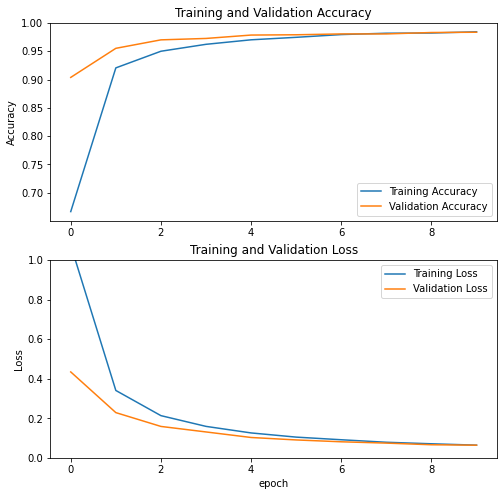

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning for better result

In [18]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [19]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [21]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/15
503/503 [==============================] - 52s 93ms/step - loss: 0.0424 - accuracy: 0.9861 - val_loss: 0.0208 - val_accuracy: 0.9940
Epoch 11/15
503/503 [==============================] - 47s 93ms/step - loss: 0.0170 - accuracy: 0.9952 - val_loss: 0.0194 - val_accuracy: 0.9940
Epoch 12/15
503/503 [==============================] - 46s 91ms/step - loss: 0.0103 - accuracy: 0.9970 - val_loss: 0.0099 - val_accuracy: 0.9965
Epoch 13/15
503/503 [==============================] - 47s 92ms/step - loss: 0.0060 - accuracy: 0.9983 - val_loss: 0.0055 - val_accuracy: 0.9980
Epoch 14/15
503/503 [==============================] - 46s 91ms/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 0.0053 - val_accuracy: 0.9980
Epoch 15/15
503/503 [==============================] - 48s 94ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.0045 - val_accuracy: 0.9985


In [22]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

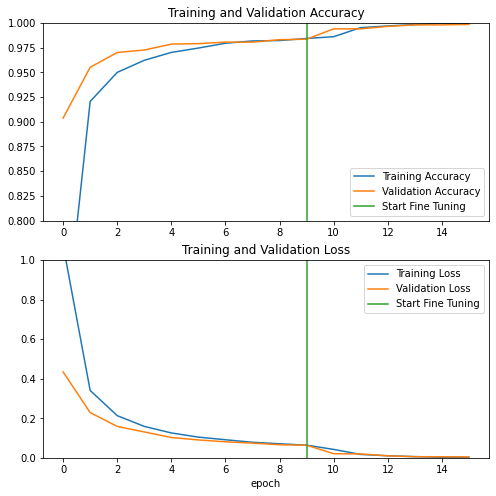

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test Model Performance with test set

In [24]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

63/63 [==============================] - 5s 69ms/step - loss: 0.0127 - accuracy: 0.9980
Test accuracy : 0.9980158805847168


Predictions:
 [7, 1, 5, 3, 2, 0, 9, 4, 6, 7, 3, 7, 7, 4, 2, 0, 3, 9, 7, 7, 6, 1, 5, 9, 5, 2, 7, 7, 8, 6, 6, 9]
Labels:
 [7, 1, 5, 3, 2, 0, 9, 4, 6, 7, 3, 7, 7, 4, 2, 0, 3, 9, 7, 7, 6, 1, 5, 9, 5, 2, 7, 7, 8, 6, 6, 9]


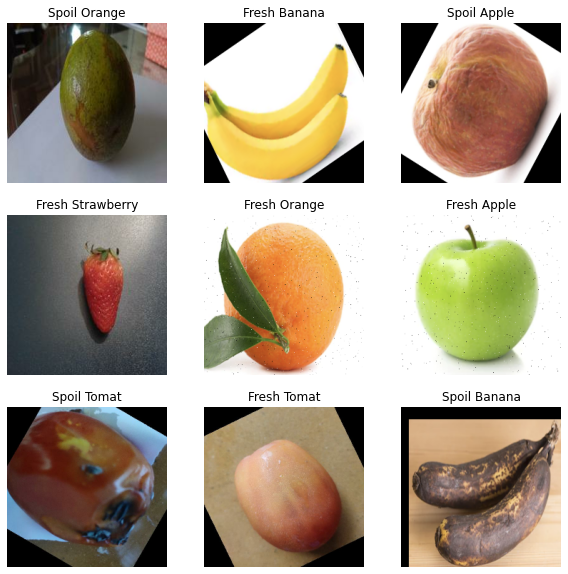

In [25]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = list(np.argmax(x) for x in predictions.numpy())

print('Predictions:\n', predictions)
print('Labels:\n', list(np.argmax(x) for x in label_batch))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

#Try Model With Custom Single Image

In [27]:
img = image.load_img(path='/content/1tomat.jpg', target_size=(224,224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
result = model.predict(img)
print(np.round_(result*100, decimals=2))

y_pred = np.argmax(result, axis=1)
print(y_pred)
if y_pred[0] == 0:
    print("Fresh Apple")
elif y_pred[0] == 1:
    print("Fresh Banana")
elif y_pred[0] == 2:
    print("Fresh Orange")
elif y_pred[0] == 3:
    print("Fresh Strawberry")
elif y_pred[0] == 4:
    print("Fresh Tomato")
elif y_pred[0] == 5:
    print("Spoil Apple")
elif y_pred[0] == 6:
    print("Spoil Banana")
elif y_pred[0] == 7:
    print("Spoil Orange")
elif y_pred[0] == 8:
    print("Spoil Strawberry")
elif y_pred[0] == 9:
    print("Spoil Tomato")

[[1.894e+01 3.000e-02 0.000e+00 1.364e+01 6.165e+01 0.000e+00 1.000e-02
  0.000e+00 0.000e+00 5.730e+00]]
[4]
Fresh Tomato


#Save Model

In [87]:
model.save('/content/Model_10_Class_Acc99.h5')